## Import

In [240]:
import pandas as pd
import xlrd
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns

## File name and experiment set-up

In [2]:
infected_file = r'data\MOI 0.01 drug screen 2.xlsx'
uninfected_file = r'data\Uninfected nCoV drug screen 2.xlsx'
n_plates = 7
n_columns = 12
n_repeats = 3
n_concentrations = 8
start_concentration = 50

## Names of compounds

In [61]:
plate = {} # <--- don't change this line!
# format is plate[number]= ['Compound1', 'Compound2', 'Compound 3']
# e.g. plate[1] = ['FD', 'BM', 'AH']
# don't worry about dmso, that's already taken care of :)
plate[1] = ['FD', 'BM', 'AH']
plate[2] = ['CH', 'TC', 'AD']
plate[3] = ['TM', 'MH', 'T']
plate[4] = ['TV', 'A', 'GH']
plate[5] = ['IM', 'F', 'CH']
plate[6] = ['HS', 'PH', 'ED']
plate[7] = ['CP', 'TaC', 'H2O']
#
plate_names = plate

## Prepare array of concentrations

In [17]:
concentrations = []
concentrations.append(start_concentration)
for i in range(1, n_concentrations):
    concentrations.append(concentrations[i-1]/2)

## Function to read data from excel file into nice dictionary of dataframes

In [19]:
def get_dict_from_excel(filename, n_plates, n_columns, infected=True):
    
    if not infected:
        _n_plates = n_plates+1
    else:
        _n_plates = n_plates
    
    start_identifier = 'Plate:'
    end_identifier = '~End'
    
    book = xlrd.open_workbook(filename=filename)
    sheet = book.sheet_by_index(0)
    row_titles = sheet.col_values(0)
    
    start_indices = []
    end_indices = []
    
    for i in range(len(row_titles)):
        row_title = row_titles[i]
        if row_title==start_identifier:
            start_indices.append(i)
        elif row_title==end_identifier:
            end_indices.append(i)
    
    data = {}
    
    for plate in range(_n_plates):
        
        vals = []
        start = start_indices[plate]+2
        end = end_indices[plate]-1
        
        for col in range(2, 2+n_columns):
            cells = sheet.col_slice(col, start, end)
            for cell in cells:
                vals.append(cell.value)
        
        vals = np.reshape(vals, (n_columns, end-start)).T
        df = pd.DataFrame(data=vals)
        
        for i in range(n_concentrations):
            df.rename(index={i:concentrations[i]}, inplace=True)
           
        if not infected:
            _plate = plate
        else:
            _plate = plate+1
        
        data[f'Plate {_plate}'] = df
        
    return data

## Function to do triplicate averaging

In [26]:
def do_triplicate_averaging(data, n_columns, n_repeats, n_plates, infected=True):
    
    if not infected:
        _n_plates = n_plates+1
    else:
        _n_plates = n_plates
    
    data_averaged = {}
    
    n_samples = int(n_columns/n_repeats)
    
    for plate in range(_n_plates):
        df = pd.DataFrame()
        
        if not infected:
            _plate = plate
        else:
            _plate = plate+1
        
        for n in range(n_samples):
            i = n*n_repeats
            j = (n+1)*n_repeats-1
            
            av_col = data[f'Plate {_plate}'].loc[:,i:j].T.mean()
            df[n] = av_col
        
        data_averaged[f'Plate {_plate}'] = df
    
    return data_averaged

## DMSO normalisations

In [48]:
def divide_by_dmso(data_averaged, n_plates, infected=True):
    
    if not infected:
        _n_plates = n_plates+1
    else:
        _n_plates = n_plates
    
    data_dmso_norm = {}

    for plate in range(_n_plates):
        
        if not infected:
            _plate = plate
        else:
            _plate = plate+1
        
        df = data_averaged[f'Plate {_plate}']
        data_dmso_norm[f'Plate {_plate}'] = df.iloc[:,:].div(df[3], axis=0)
        
    return data_dmso_norm

def subtract_by_dmso(data_averaged, n_plates, infected=True):
    
    if not infected:
        _n_plates = n_plates+1
    else:
        _n_plates = n_plates
    
    data_dmso_norm = {}

    for plate in range(_n_plates):
        
        if not infected:
            _plate = plate
        else:
            _plate = plate+1
        
        df = data_averaged[f'Plate {_plate}']
        data_dmso_norm[f'Plate {_plate}'] = df.iloc[:,:].subtract(df[3], axis=0)
        
    return data_dmso_norm

## Export as csv

In [104]:
def write_plate_to_csv(save_path, plate_ind, inf_data, uninf_data, plate_names):
    
    headers = ['Concentration (uM)']
    for name in plate_names[plate_ind]:
        headers.append(name)
        
    this_inf = np.asarray(inf_data[f'Plate {plate_ind}'])
    this_uninf = np.asarray(uninf_data[f'Plate {plate_ind}'])
    
    n_rows = this_inf.shape[0]
    
    with open(f'.\{save_path}\Plate_{plate_ind}_inf.csv', 'w') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',')
        csvwriter.writerow(headers)
        
        for n in range(n_rows):
            row = this_inf[n, 0:3]
            row = np.insert(row, 0, concentrations[n])
            csvwriter.writerow(row)
            
    with open(f'.\{save_path}\Plate_{plate_ind}_uninf.csv', 'w') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',')
        csvwriter.writerow(headers)
        
        for n in range(n_rows):
            row = this_uninf[n, 0:3]
            row = np.insert(row, 0, concentrations[n])
            csvwriter.writerow(row)
    

In [105]:
for i in range(n_plates):
    _plate = i+1

    write_plate_to_csv('out', _plate, inf_data_dmso_div, uninf_data_dmso_div, plate_names)

## Functions for toxicity and inhibition calculation

In [184]:
def get_toxicity(drug, cell, blank=0):
    
    _drug = np.subtract(drug, blank)
    _cell = np.subtract(cell, blank)

    tox = 1 - np.divide(_drug, _cell)
    
    return tox*100

In [194]:
def get_inhibition(drug, cell, vehicle_drug, vehicle_cell):
    
    _drug = np.subtract(drug, vehicle_drug)
    _cell = np.subtract(cell, vehicle_cell)

    inhib = np.divide(_drug, _cell)
    
    return inhib*100

(-100, 100)

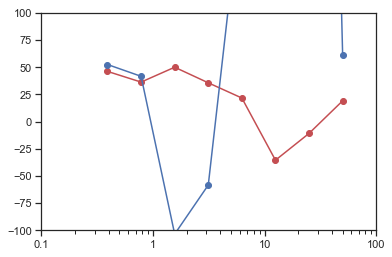

In [307]:
inf_data = get_dict_from_excel(infected_file, n_plates, n_columns)
uninf_data = get_dict_from_excel(uninfected_file, n_plates, n_columns, infected=False)

inf_array = np.asarray(inf_data['Plate 1']).T
uninf_array = np.asarray(uninf_data['Plate 1']).T
plate_0 = np.asarray(uninf_data['Plate 0']).T

tox = get_toxicity(inf_array[2], uninf_array[2])
inhib = get_inhibition(inf_array[2], uninf_array[2], np.mean(inf_array[9:12], axis=0), np.mean(uninf_array[9:12], axis=0))
plt.plot(concentrations, tox, 'ro-')
plt.plot(concentrations, inhib, 'bo-')
plt.xscale('log')
plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])
plt.ylim([-100, 100])

In [308]:
def format_plot(xdata, ydata, xlabel=None, ylabel=None, title=None, ylim=None, xticks=None, hlines=None, logx=True):
    
    label_style = ['large', 'semibold']
    marker_style = 'o'
    color_order = ['b','r','g']
    
    plt.figure(figsize=[4.8, 4.8])
    plt.hlines(hlines, xticks[0], xticks[-1], linestyle=':')    
    
    if ydata.ndim==2:       
        for y in ydata:
            plt.plot(xdata, y, marker=marker_style)
    else:
        plt.plot(xdata, ydata, marker=marker_style, color='b')
    
    if logx:
        plt.xscale('log')
        
        
    plt.xlabel(xlabel, fontsize=label_style[0], fontweight=label_style[1])
    plt.ylabel(ylabel, fontsize=label_style[0], fontweight=label_style[1])
            
    plt.tick_params(direction='in')
    plt.xticks(xticks, xticks)


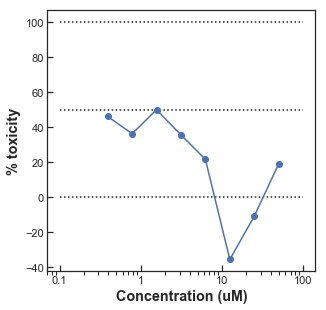

In [311]:
format_plot(concentrations, tox, xlabel='Concentration (uM)', ylabel='% toxicity', xticks=[0.1,1,10,100], hlines=[0,50,100])

In [158]:
def subtract_by_dmso(data_averaged, n_plates, infected=True):
    
    if not infected:
        _n_plates = n_plates+1
    else:
        _n_plates = n_plates
    
    data_dmso_norm = {}
    
    for plate in range(_n_plates):
        
        if not infected:
            _plate = plate
        else:
            _plate = plate+1
        
        df = data_averaged[f'Plate {_plate}']
        data_dmso_norm[f'Plate {_plate}'] = df.iloc[:,:].subtract(data_averaged[f'Plate {_plate}'].loc[:,9:11].T.mean(), axis=0)
        
    return data_dmso_norm

In [157]:
inf_data['Plate 1'].loc[:,9:11].T.mean()

50.000000    2.110598e+07
25.000000    2.525130e+07
12.500000    2.055371e+07
6.250000     1.989877e+07
3.125000     2.404221e+07
1.562500     2.057708e+07
0.781250     1.988310e+07
0.390625     1.635824e+07
dtype: float64

In [162]:
test = subtract_by_dmso(inf_data, n_plates)
test_uninf = subtract_by_dmso(uninf_data, n_plates, infected=False)
test_av = do_triplicate_averaging(test, n_columns, n_repeats, n_plates)
test_av_uninf = do_triplicate_averaging(test_uninf, n_columns, n_repeats, n_plates, infected=False)

In [168]:
test_array = np.asarray(test_av['Plate 1']).T
test_array_uninf = np.asarray(test_av_uninf['Plate 1']).T
div = np.divide(test_array, test_array_uninf)

In [171]:
div*100

array([[ 1.64282052e+02,  6.23414262e+01,  2.22300469e+02,
         1.56697959e+02, -1.03874981e+02, -6.80781117e+01,
        -1.21595836e+02, -2.32814250e+01],
       [-1.23472742e+03,  1.94111554e+02,  2.51485347e+02,
         6.44825076e+01, -8.05501619e+01, -5.59267283e+01,
        -4.20618450e+01,  5.10375219e+00],
       [-1.72831473e+01,  5.19415029e+03,  4.91615344e+02,
         5.98474993e+02,  2.27289404e+02,  2.18765170e+02,
         1.18523061e+02,  1.69999300e+02],
       [ 5.00000000e+01, -5.00000000e+01, -3.33333333e+01,
        -2.50000000e+02,  2.00000000e+02,  1.00000000e+02,
        -2.00000000e+02, -7.50000000e+01]])